# Baseline Model

Before model selection a simpel model must be run to act as a baseline for compaison of model performance. For this baseline we will use a simple Random Forest Regressor to predic the Mid-Price in 20 ticks time. 

The baseline model will be trained using a simple featureset consiting solely of data from the first level of the Limit Order Book.

### Import Libraries

In [4]:
#import required libraries
from utils import aws # used to create aws session and load parquet 
import pandas as pd
import numpy as np
import ast 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dask.dataframe as dd


### Load Dataset

Currently this is run using the sample dataset, but going forward will need to be run using the full LOB dataset.

In [16]:
#load sample feature set from s3 to a dask dataframe
# lob_ddf = aws.load_s3_file_as_ddf("s3://dsmp-ol2/processed-data/full_normalised_lob_feature_set.parquet")

columns_to_keep = [
    'Timestamp', 'Mid_Price_Raw',
    'Mid_Price_EMA_Short_z-score_normalised'
]

lob_ddf = dd.read_parquet('data/full_normalised_lob_feature_set.parquet', columns=columns_to_keep)

In [17]:
#compute the dask dataframe to a pandas dataframe
df = lob_ddf.compute()

In [19]:
df

,Timestamp,Mid_Price_Raw,Mid_Price_EMA_Short_z-score_normalised
3,2.449,91.5,-2.790405
4,2.945,92.0,-2.787987
5,3.193,98.5,-2.754575
6,3.689,99.0,-2.724821
7,4.650,98.5,-2.702894
...,...,...,...
41238688,30599.697,208.5,-0.019140
41238689,30599.728,208.5,-0.009797
41238690,30599.790,208.5,-0.002152
41238691,30599.821,208.5,0.004103


### Create Target Column

The baseline model will be used to predict the future Mid-Price at a single horizon. 

#### Set the Horizon

In [20]:
# The horizon is how far in the future the Mid-Proce is being predicted
horizon = 5

In [21]:
df['Target'] = df['Mid_Price_EMA_Short_z-score_normalised'].shift(-horizon)

# Drop rows where all values in the 'Target' column are NaN
df.dropna(subset=['Target'], how='all', inplace=True)

df

,Timestamp,Mid_Price_Raw,Mid_Price_EMA_Short_z-score_normalised,Target
3,2.449,91.5,-2.790405,-2.687371
4,2.945,92.0,-2.787987,-2.321649
5,3.193,98.5,-2.754575,-2.022422
6,3.689,99.0,-2.724821,-1.775182
7,4.650,98.5,-2.702894,-1.572894
...,...,...,...,...
41238683,30599.387,207.0,-0.079843,-0.019140
41238684,30599.480,207.0,-0.067323,-0.009797
41238685,30599.542,207.5,-0.054460,-0.002152
41238686,30599.635,208.0,-0.041315,0.004103


In [22]:
def create_sequences(df, seq_length):
    data = df.values  # Convert the entire DataFrame to a NumPy array first
    num_samples = data.shape[0] - seq_length + 1
    X = np.zeros((num_samples, seq_length, data.shape[1] - 1))
    y = np.zeros((num_samples,))

    for i in range(num_samples):
        X[i] = data[i:i + seq_length, :-1]  # all features except the last
        y[i] = data[i + seq_length - 1, -1]  # the last feature (target)
    return X, y

seq_length = 10  # Number of timesteps in each sequence
X, y = create_sequences(df, seq_length)


In [23]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Flatten the data to fit the scaler, then reshape back to the original
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)


In [25]:
# Define the Bidirectional LSTM model
import torch
import torch.nn as nn

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BidirectionalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x


In [26]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

model = BidirectionalLSTM(input_dim=X_train.shape[2], hidden_dim=50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  # To reduce overfitting
criterion = nn.MSELoss()



/Users/adam/Documents/uni/Year 2/DSMP/dsmp-2024-group-ol2/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [27]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for data, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.2148120403289795
Epoch 2, Loss: 0.17626141011714935
Epoch 3, Loss: 0.03325263783335686
Epoch 4, Loss: 0.09169939160346985
Epoch 5, Loss: 0.2885514497756958
Epoch 6, Loss: 0.01926012896001339
Epoch 7, Loss: 0.07045423984527588
Epoch 8, Loss: 0.24812732636928558
Epoch 9, Loss: 0.008830005303025246
Epoch 10, Loss: 0.2237495481967926


In [28]:
torch.save(model, 'models/lstm_model.pth')
torch.save(model.state_dict(), 'models/lstm_model_state_dict.pth')

In [29]:
# Ensure the model is in evaluation mode
model.eval()

# DataLoader for the test set
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# No gradient computation is needed for evaluation
with torch.no_grad():
    test_predictions = []
    test_targets = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_predictions.extend(outputs.view(-1).tolist())
        test_targets.extend(targets.view(-1).tolist())

# Convert predictions and actual values to tensors for loss computation
test_predictions_tensor = torch.tensor(test_predictions)
test_targets_tensor = torch.tensor(test_targets)

# Calculate R^2, MSE and RMSE
r2 = r2_score(test_predictions_tensor, test_targets_tensor)
mse = torch.nn.functional.mse_loss(test_predictions_tensor, test_targets_tensor)
rmse = torch.sqrt(mse)

print(f'R^2 Score: {r2}')
print(f'Test MSE: {mse.item()}')
print(f'Test RMSE: {rmse.item()}')


R^2 Score: 0.9102405272546118
Test MSE: 0.11354019492864609
Test RMSE: 0.33695724606513977


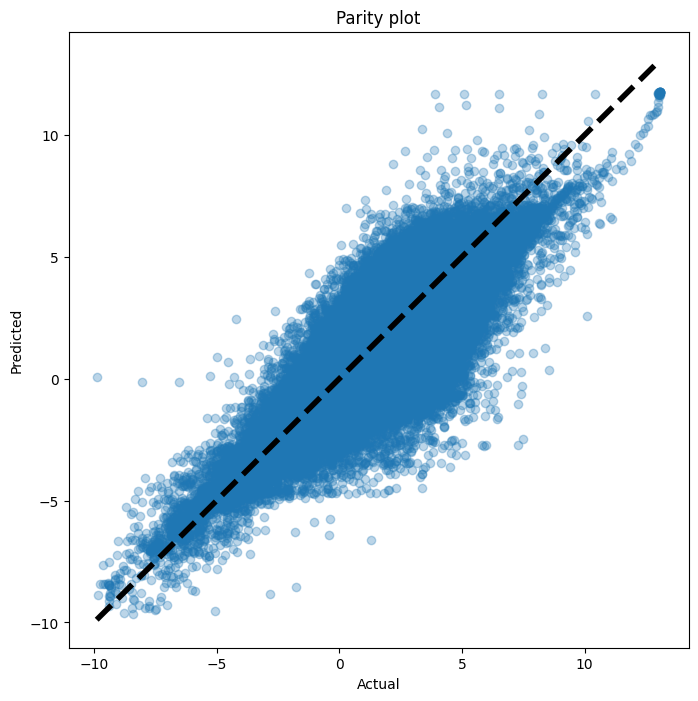

In [31]:
# parity plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(test_targets_tensor, test_predictions_tensor, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Parity plot')
plt.show()